Получим обучающий и тестовый датасеты, предварительно для удобства загруженные на Github. Проверив данные датасета, видим что пропуски встречаются в менее чем 1000 строк из более 10000, значит, их можно удалить. Также удаляем столбец ID из тестового датасета, чтобы сделать его структуру идентичной обучающему. Проверим параметры на предмет выбросов.

<class 'pandas.core.frame.DataFrame'>
Index: 10487 entries, 0 to 11016
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ApplicationDate             10487 non-null  object 
 1   Age                         10487 non-null  float64
 2   AnnualIncome                10487 non-null  float64
 3   CreditScore                 9986 non-null   float64
 4   LoanAmount                  9986 non-null   float64
 5   LoanDuration                10487 non-null  float64
 6   MaritalStatus               10487 non-null  object 
 7   NumberOfDependents          10487 non-null  float64
 8   HomeOwnershipStatus         10487 non-null  object 
 9   MonthlyDebtPayments         9986 non-null   float64
 10  CreditCardUtilizationRate   10487 non-null  float64
 11  NumberOfOpenCreditLines     10487 non-null  float64
 12  NumberOfCreditInquiries     10487 non-null  float64
 13  DebtToIncomeRatio           10487 no

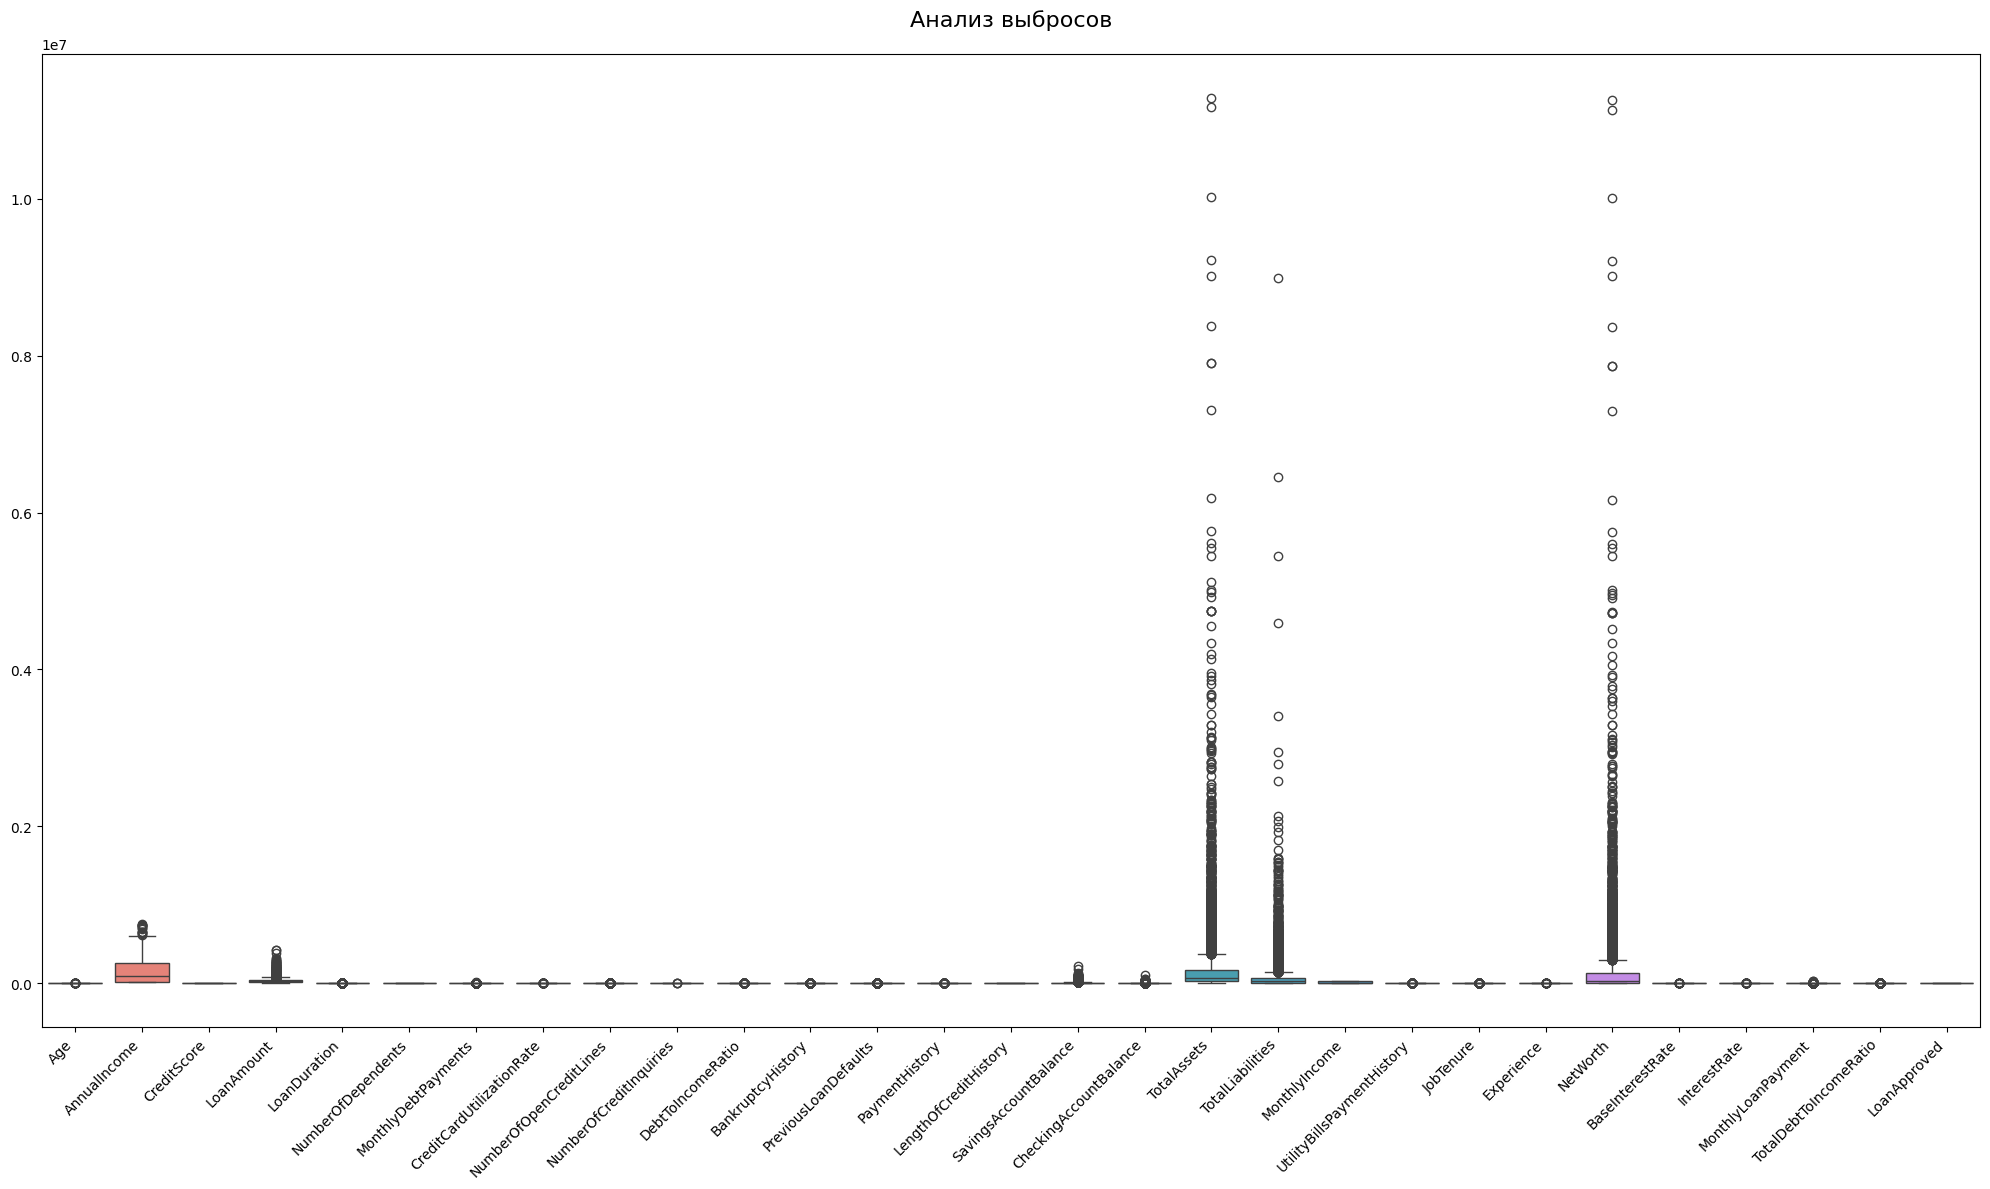

In [1]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/MMVlasko/ml/refs/heads/main/train_c.csv").dropna(how='all')

df.info()
df = df.dropna()
test_df = pd.read_csv("https://raw.githubusercontent.com/MMVlasko/ml/refs/heads/main/test_c.csv").dropna(how='all').drop(columns=['ID'])

df.info()


import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.figure(figsize=(20, 12))
sns.boxplot(df)
plt.title("Анализ выбросов", fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

Cразу удалим из рассмотрения признак ApplicationDate, как явно бесполезный для анализа.

In [2]:
import seaborn as sns

df = df.drop(columns=['ApplicationDate'])
test_df = test_df.drop(columns=['ApplicationDate'])

Далее произведём общую обработку выбросов с использованием метода винсоризации.

In [3]:
cols_to_cap = df.select_dtypes(include=[np.number]).columns.drop('LoanApproved')

for col in cols_to_cap:

    lower_limit = df[col].quantile(0.02)

    upper_limit = df[col].quantile(0.99)

    df[col] = df[col].clip(lower=lower_limit, upper=upper_limit)

    test_df[col] = test_df[col].clip(lower=lower_limit, upper=upper_limit)

Преобразуем категориальные признаки к числовому виду с помощью LabelEncoder.

In [4]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}

for column in df.select_dtypes(include=['object']).columns.tolist():
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

for column in test_df.select_dtypes(include=['object']).columns.tolist():
    le = LabelEncoder()
    test_df[column] = le.fit_transform(test_df[column])

Стандартизирем нецелевые признаки для приведения признаков к одному масштабу с помощью StandardScaler.

In [5]:
from sklearn.preprocessing import StandardScaler
numeric_cols_to_scale = [col for col in df.columns if col != 'LoanApproved']
scaler = StandardScaler()
df_standardized = df.copy()
df_standardized[numeric_cols_to_scale] = scaler.fit_transform(df[numeric_cols_to_scale])
df = df_standardized

test_df_standardized = test_df.copy()
test_df_standardized[numeric_cols_to_scale] = scaler.transform(test_df[numeric_cols_to_scale])
test_df = test_df_standardized

Так как для рассмотренных в этой работе моделей добавление нелинейных комбинаций не дало сколько-нибудь существенного улучшения метрик, оставим только исходные признаки и рассмотрим матрицу их частичных корреляций.

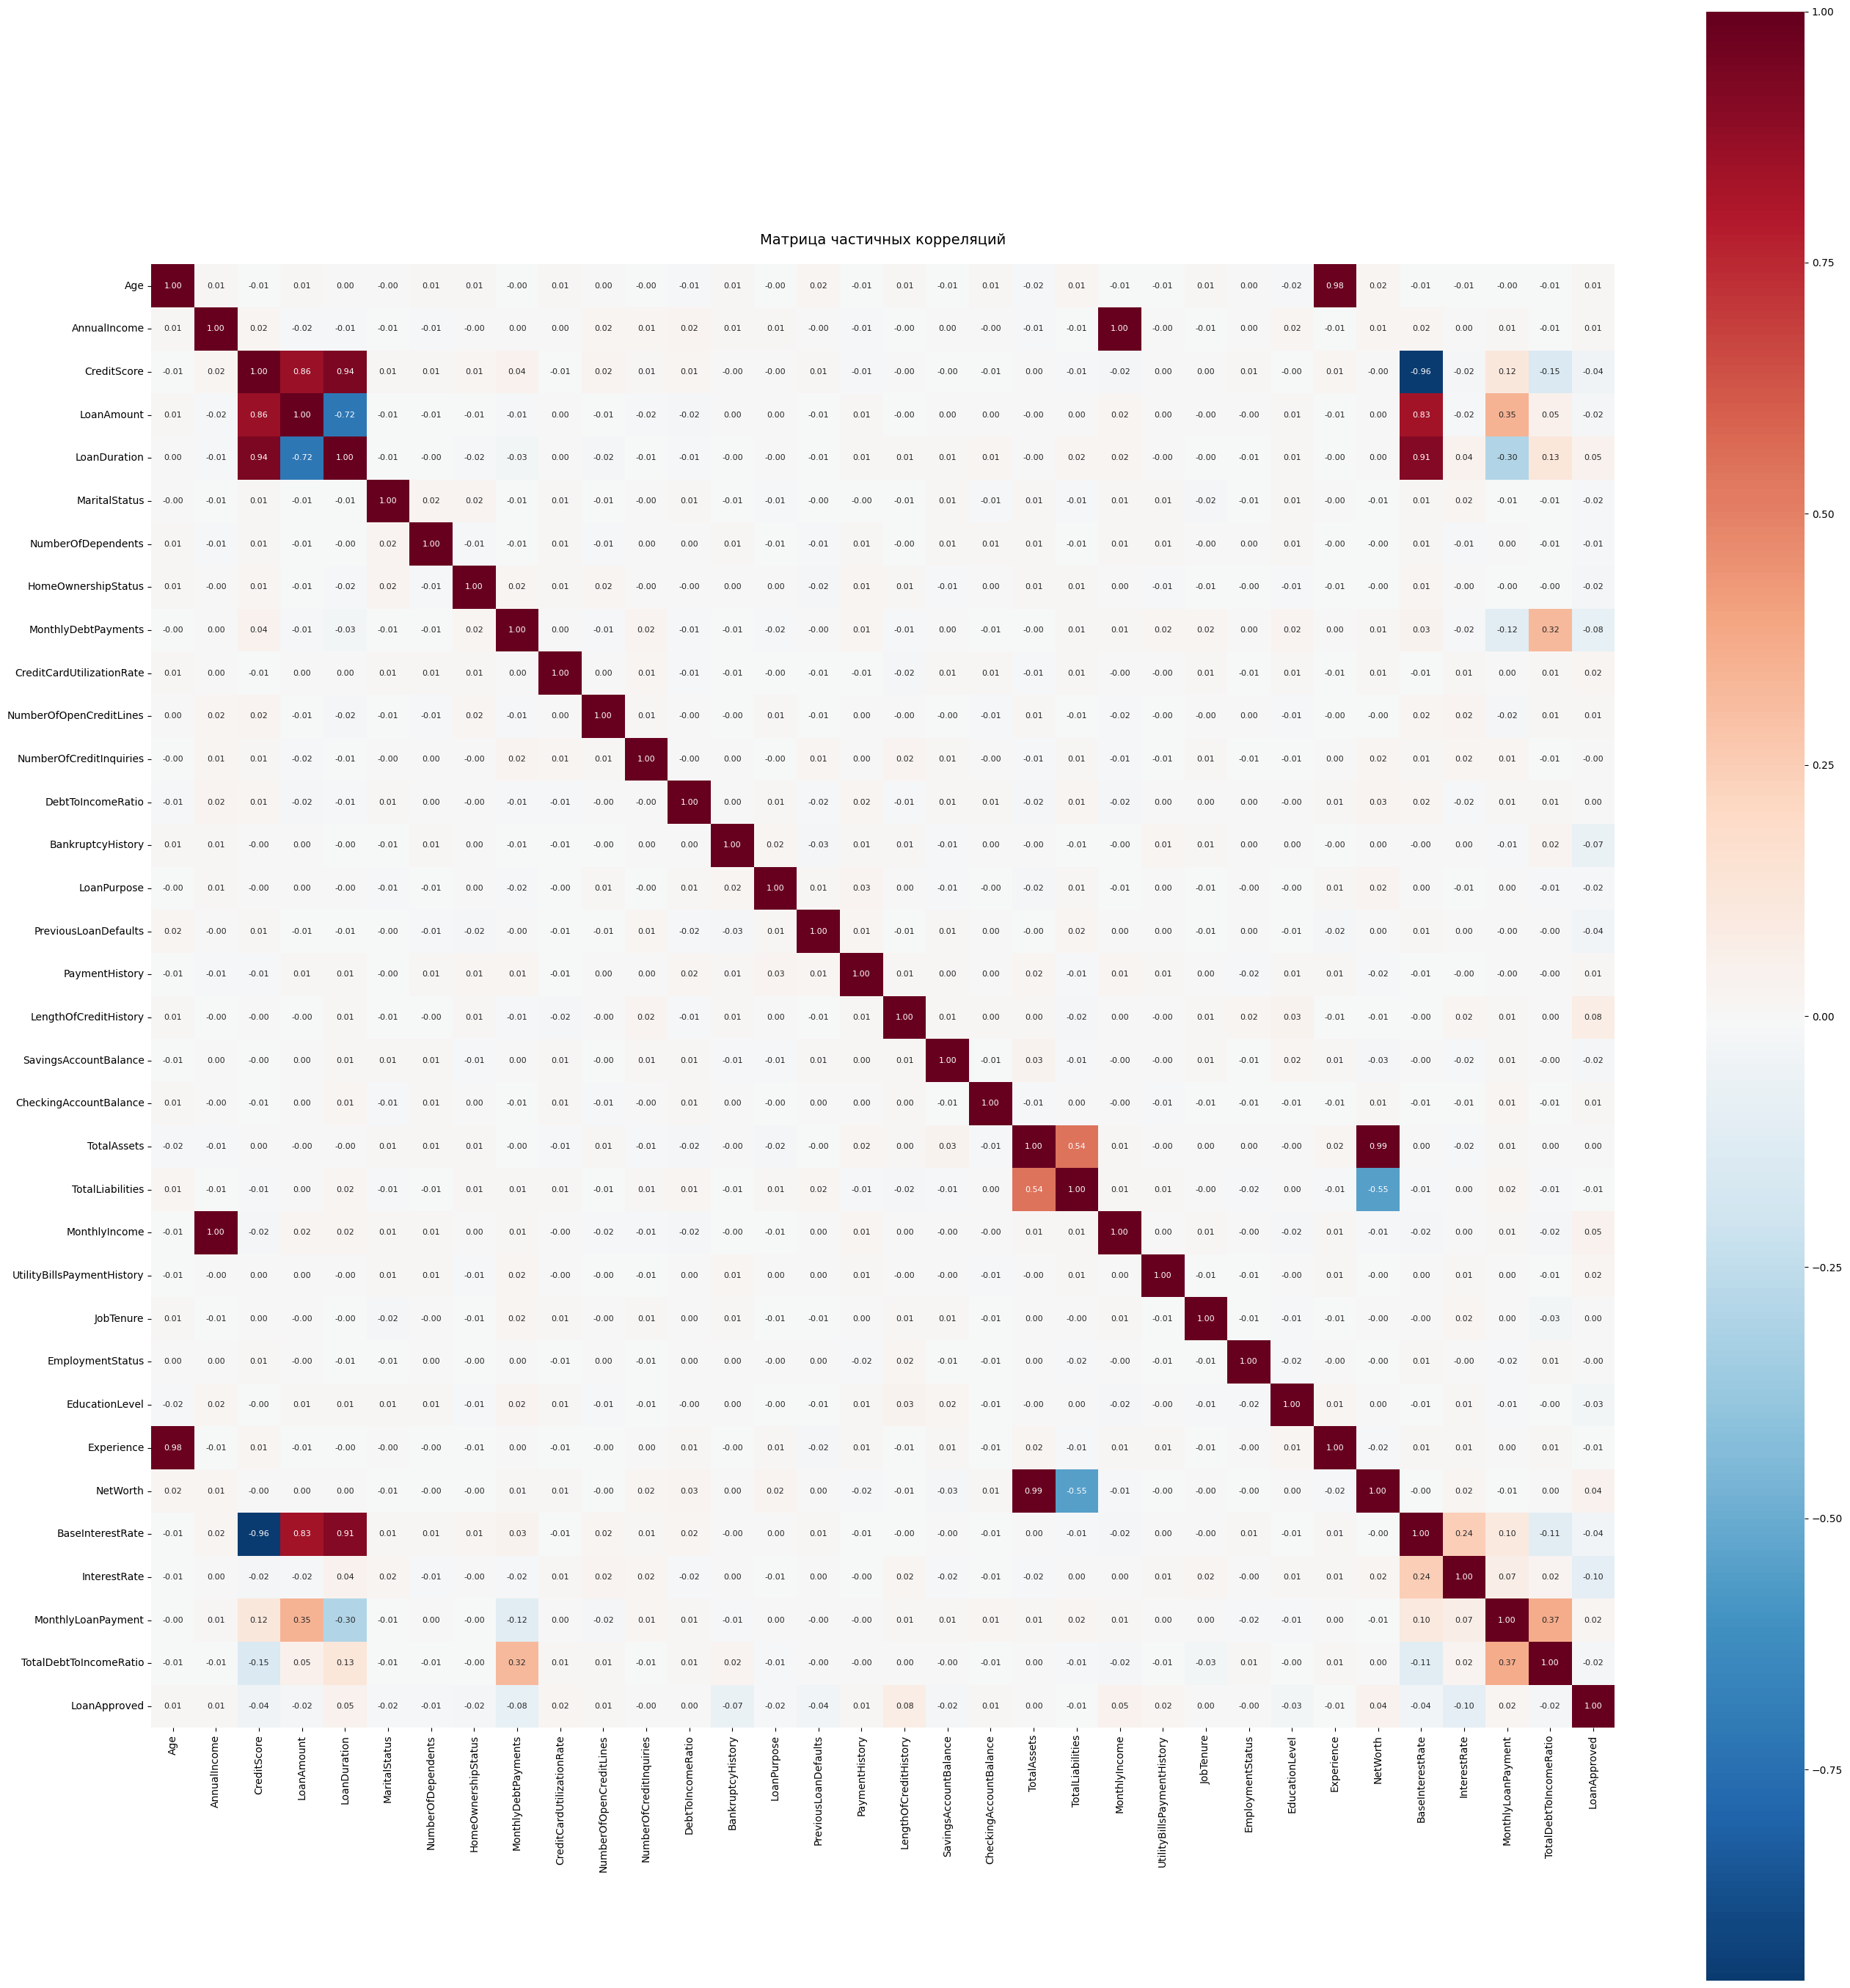

In [6]:
from scipy import stats

def plot_partial_correlation_matrix(df):
    numeric_df = df.select_dtypes(include=[np.number])

    n_features = len(numeric_df.columns)
    X = numeric_df.values

    partial_corr = np.eye(n_features)

    for i in range(n_features):
        for j in range(i + 1, n_features):
            other_features = [k for k in range(n_features) if k != i and k != j]

            if len(other_features) == 0:
                corr, _ = stats.pearsonr(X[:, i], X[:, j])
            else:
                X_other = X[:, other_features]

                coeff_i = np.linalg.lstsq(X_other, X[:, i], rcond=None)[0]
                residuals_i = X[:, i] - X_other @ coeff_i

                coeff_j = np.linalg.lstsq(X_other, X[:, j], rcond=None)[0]
                residuals_j = X[:, j] - X_other @ coeff_j

                corr, _ = stats.pearsonr(residuals_i, residuals_j)

            partial_corr[i, j] = corr
            partial_corr[j, i] = corr

    partial_corr_df = pd.DataFrame(
        partial_corr,
        index=numeric_df.columns,
        columns=numeric_df.columns
    )

    fig_size = max(8, len(numeric_df.columns) * 0.8)

    plt.figure(figsize=(fig_size, fig_size))
    sns.heatmap(partial_corr_df,
                annot=True,
                fmt='.2f',
                cmap='RdBu_r',
                center=0,
                square=True,
                annot_kws={'size': min(12, max(8, 100 // len(numeric_df.columns)))})
    plt.title('Матрица частичных корреляций', fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

plot_partial_correlation_matrix(df)

Сильно коррелированных пар немного, удалим лишние признаки вручную.

In [7]:
to_drop = ['BaseInterestRate', 'MonthlyIncome', 'Age', 'TotalAssets', 'LoanDuration']
df = df.drop(columns=to_drop)
test_df = test_df.drop(columns=to_drop)

Разделим обучающий дататсет на обучающую и валидационную выборки. Обучим несколько моделей разных типов и сравним различные метрики. Сохраним для дальнейшего использования модель, которая покажет наибольший ROC-AUC.

In [8]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, precision_recall_curve, auc
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, precision_recall_curve, auc
import pandas as pd
import numpy as np

def find_best_model(df, target_column, test_size=0.2, random_state=42):
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    X_train, X_val, y_train, y_val = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )

    models = {
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=random_state),
        'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=random_state),
        'ExtraTrees': ExtraTreesClassifier(n_estimators=100, random_state=random_state),
        'LogisticRegression': LogisticRegression(random_state=random_state),
        'SVM': SVC(probability=True, random_state=random_state),
        'KNN': KNeighborsClassifier(),
        'DecisionTree': DecisionTreeClassifier(random_state=random_state)
    }

    results = {}
    best_model = None
    best_roc_auc = 0
    best_model_name = ""

    for model_name, model in models.items():
        try:
            model.fit(X_train, y_train)

            y_val_pred_class = model.predict(X_val)

            y_val_pred_proba = model.predict_proba(X_val)[:, 1]

            roc_auc = roc_auc_score(y_val, y_val_pred_proba)

            precision = precision_score(y_val, y_val_pred_class)
            recall = recall_score(y_val, y_val_pred_class)
            f1 = f1_score(y_val, y_val_pred_class)

            precision_curve, recall_curve, _ = precision_recall_curve(y_val, y_val_pred_proba)
            pr_auc = auc(recall_curve, precision_curve)

            results[model_name] = {
                'model': model,
                'roc_auc': roc_auc,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'pr_auc': pr_auc,
                'predictions_class': y_val_pred_class,
                'predictions_proba': y_val_pred_proba
            }

            if roc_auc > best_roc_auc:
                best_model = model
                best_roc_auc = roc_auc

            print(f"{model_name:.<20} ROC-AUC = {roc_auc:.4f} | Precision = {precision:.4f} | Recall = {recall:.4f} | F1 = {f1:.4f} | PR-AUC = {pr_auc:.4f}")

        except Exception as e:
            print(f"{model_name:.<20} Ошибка: {e}")
            continue

    sorted_results = dict(sorted(results.items(), key=lambda x: x[1]['roc_auc'], reverse=True))
    print("-" * 80)
    for i, (model_name, result) in enumerate(sorted_results.items(), 1):
        print(f"{i:2}. {model_name:.<18} ROC-AUC: {result['roc_auc']:.4f} | F1: {result['f1_score']:.4f} | Precision: {result['precision']:.4f} | Recall: {result['recall']:.4f}")

    return best_model

model = find_best_model(df, 'LoanApproved')

RandomForest........ ROC-AUC = 0.9802 | Precision = 0.9261 | Recall = 0.9307 | F1 = 0.9284 | PR-AUC = 0.9811
GradientBoosting.... ROC-AUC = 0.9846 | Precision = 0.9312 | Recall = 0.9385 | F1 = 0.9348 | PR-AUC = 0.9854
ExtraTrees.......... ROC-AUC = 0.9828 | Precision = 0.9303 | Recall = 0.9258 | F1 = 0.9280 | PR-AUC = 0.9834
LogisticRegression.. ROC-AUC = 0.9862 | Precision = 0.9332 | Recall = 0.9414 | F1 = 0.9373 | PR-AUC = 0.9872
SVM................. ROC-AUC = 0.9826 | Precision = 0.9300 | Recall = 0.9346 | F1 = 0.9323 | PR-AUC = 0.9832
KNN................. ROC-AUC = 0.9299 | Precision = 0.8411 | Recall = 0.8838 | F1 = 0.8619 | PR-AUC = 0.9330
DecisionTree........ ROC-AUC = 0.8971 | Precision = 0.9066 | Recall = 0.8906 | F1 = 0.8985 | PR-AUC = 0.9266
--------------------------------------------------------------------------------
 1. LogisticRegression ROC-AUC: 0.9862 | F1: 0.9373 | Precision: 0.9332 | Recall: 0.9414
 2. GradientBoosting.. ROC-AUC: 0.9846 | F1: 0.9348 | Precision: 0.

Наилучший результат по ROC-AUC показала модель логистической регрессии. Попытаемся с помощью различных методов подобрать гиперпараметры для неё так, чтобы максимизировать метрику.

In [17]:
# !pip install optuna

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, auc, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
import optuna
optuna.logging.disable_default_handler()
from scipy.stats import uniform

def optimize_logistic_regression_fixed(df, target_column, method='grid', n_trials=114, test_size=0.2, random_state=42):
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    param_grid = [
      {
          'penalty': [None],
          'solver': ['lbfgs', 'newton-cg', 'saga'],
          'max_iter': [1000, 2000]
      },
      {
          'penalty': ['l1'],
          'solver': ['liblinear', 'saga'],
          'C': [0.001, 0.01, 0.1, 1, 10, 100],
          'max_iter': [1000, 2000]
      },
      {
          'penalty': ['l2'],
          'solver': ['liblinear', 'lbfgs', 'newton-cg', 'saga'],
          'C': [0.001, 0.01, 0.1, 1, 10, 100],
          'max_iter': [1000, 2000]
      },
      {
          'penalty': ['elasticnet'],
          'solver': ['saga'],
          'C': [0.001, 0.01, 0.1, 1, 10, 100],
          'l1_ratio': [0.1, 0.5, 0.9],
          'max_iter': [2000, 5000]
      }
    ]

    if method == 'grid':
        search = GridSearchCV(
            LogisticRegression(random_state=random_state),
            param_grid,
            cv=3,
            scoring='roc_auc'
        )
        search.fit(X_train, y_train)

        best_model = search.best_estimator_
        best_params = search.best_params_

    elif method == 'random':
        search = RandomizedSearchCV(
            LogisticRegression(random_state=random_state),
            param_grid,
            n_iter=n_trials,
            cv=3,
            scoring='roc_auc'
        )
        search.fit(X_train, y_train)

        best_model = search.best_estimator_
        best_params = search.best_params_

    elif method == 'optuna':
        def objective(trial):
            C = trial.suggest_float('C', 0.001, 100, log=True)
            penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet'])
            max_iter = trial.suggest_int('max_iter', 1000, 5000)

            solver = trial.suggest_categorical('solver', ['saga'])

            if penalty == 'elasticnet':
                l1_ratio = trial.suggest_float('l1_ratio', 0.1, 0.9)
                model = LogisticRegression(
                    C=C,
                    penalty=penalty,
                    solver=solver,
                    max_iter=max_iter,
                    l1_ratio=l1_ratio,
                    random_state=random_state
                )
            else:
                model = LogisticRegression(
                    C=C,
                    penalty=penalty,
                    solver=solver,
                    max_iter=max_iter,
                    random_state=random_state
                )

            model.fit(X_train, y_train)

            y_val_proba = model.predict_proba(X_val)[:, 1]
            roc_auc = roc_auc_score(y_val, y_val_proba)
            return roc_auc

        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=n_trials)

        best_params = study.best_params
        model_params = {k: v for k, v in best_params.items() if k != 'solver'}
        best_model = LogisticRegression(**model_params, solver='saga', random_state=random_state)
        best_model.fit(X_train, y_train)

    y_val_proba = best_model.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, y_val_proba)

    y_val_pred = best_model.predict(X_val)
    precision = precision_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)

    precision_curve, recall_curve, _ = precision_recall_curve(y_val, y_val_proba)
    pr_auc = auc(recall_curve, precision_curve)

    return best_model, roc_auc, precision, recall, f1, pr_auc, best_params

for method in ['grid', 'random', 'optuna']:
    model, roc_auc, precision, recall, f1, pr_auc, params = optimize_logistic_regression_fixed(df, 'LoanApproved', method=method)
    print(f"\n-------- {method}: ROC-AUC = {roc_auc:.4f} Precision = {precision:.4f}, Recall = {recall:.4f}, F1-score = {f1:.4f}, PR-AUC = {pr_auc:.4f}, params = {params}\n")


-------- grid: ROC-AUC (на вероятностях) = 0.9863 Precision = 0.9331, Recall = 0.9404, F1-score = 0.9368, PR-AUC = 0.9873, params = {'C': 1, 'l1_ratio': 0.5, 'max_iter': 2000, 'penalty': 'elasticnet', 'solver': 'saga'}


-------- random: ROC-AUC (на вероятностях) = 0.9863 Precision = 0.9331, Recall = 0.9404, F1-score = 0.9368, PR-AUC = 0.9873, params = {'solver': 'saga', 'penalty': 'elasticnet', 'max_iter': 2000, 'l1_ratio': 0.5, 'C': 1}


-------- optuna: ROC-AUC (на вероятностях) = 0.9864 Precision = 0.9332, Recall = 0.9414, F1-score = 0.9373, PR-AUC = 0.9873, params = {'C': 41.516782181429974, 'penalty': 'l2', 'max_iter': 3895, 'solver': 'saga'}



В результате оптимизации гиперпараметров с использованием GridSearch и RandomizedSearch по метрикам получены одинаковые и чуть большие чем при обучениии без оптимизации значения метрик (так как для обоих методов использовался одинаковый и фиксированный набор возможных значений гиперпараметров). С помощью optuna удалось незначительно увеличить метрики, в том числе целевую на 0.0002, что приемлемо для изначально большого значения ROC-AUC.

Получаем предсказания по тестовому датасету с помощью лучшей по итогу предыдущих шагов модели, формируем требуемый формат ответа.

In [15]:
y_pred = model.predict_proba(test_df)[:, 1]

result = pd.DataFrame({
    'ID': range(len(y_pred)),
    'LoanApproved': y_pred
})

result.to_csv('predictions.csv', index=False)

Скачиваем сохранённый файл.

In [16]:
from google.colab import files
files.download('predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>